## Look at bauer risk model results

originally used it for degubbing,( tried plein RiskLapseModel simple with lesss subjects) compared it to Miguel's data (from bauer.utils.data import load_garcia2022) --> now in test_klw_model.ipynb

* posteriors:
    * readable control/dyscalc parameter estimates posteriors

In [ ]:
import os.path as op
import os
import numpy as np
import pandas as pd

bids_folder = '/Users/mrenke/data/ds-dnumrisk'


In [3]:
from utils_02 import build_model
from utils import get_data
import arviz as az

df = get_data()

model_label = '4'
format = 'non-symbolic'

df = df.xs(format,0, level='format')


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [3]:
# debugging with less subjects
from bauer.models import RiskLapseModel

specification = 'sub1-10'
subList = [1,2,3,4,5,6,7,8,9,10]
df = df.loc[df.index.get_level_values('subject').isin(subList)] # only 10 subs to check model fitting

df['choice'] = df['chose_risky'] ##
df.head()
df.to_csv(op.join(bids_folder, 'interim_sum_data', f'risk-data_{specification}.csv'))
# only needs df_mig.columns.values = ['p1','p2',n1','n2','log(risky/safe)','choice']
# df = df[['p1','p2','n1','n2','log(risky/safe)','choice']
df.to_csv(op.join(bids_folder, 'interim_sum_data', f'risk-data_{specification}.csv'))
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')

model_label = 'RiskLapseModel'
burnin=1000
samples=1000
model = RiskLapseModel(...)
model.build_estimation_model()
trace = model.sample(burnin, samples, target_accept=0.9)
az.to_netcdf(trace, '/Users/mrenke/Desktop/tryout_trace.netcdf')

### look at posteriors, e.g. PPCs

In [1]:
idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels_risk/', f'model-{model_label}_format-{format}_trace.netcdf'))

NameError: name 'az' is not defined

             prior_sd          
              hdi_low  hdi_high
subject                        
1        8.316467e-01  4.711101
2        1.022504e+00  4.928301
3        4.199734e-29  3.958654
4        3.558186e-18  4.021369
5        1.639028e-53  4.101005
6        8.513889e-01  4.853323
7        8.453828e-01  4.650259
8        2.231103e-41  4.132472
9        7.271015e-01  4.832701
10       5.199164e-01  4.616786


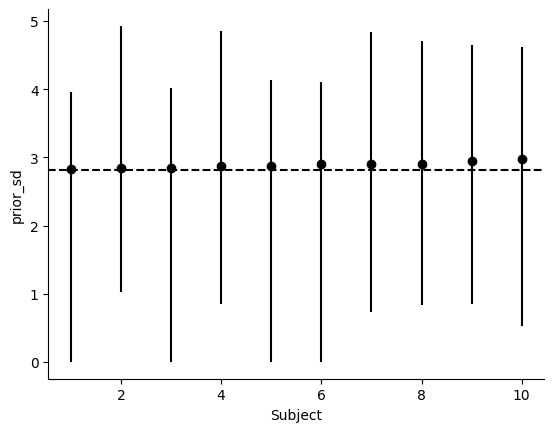

In [26]:
from bauer.utils.plotting import plot_subjectwise_parameters
plot_subjectwise_parameters(idata, parameter='prior_sd')

            rnp          
        hdi_low  hdi_high
subject                  
1           0.0  0.426225
2           0.0  0.392977
3           0.0  0.378763
4           0.0  0.384164
5           0.0  0.379473
6           0.0  0.407491
7           0.0  0.458903
8           0.0  0.431819
9           0.0  0.416308
10          0.0  0.548021


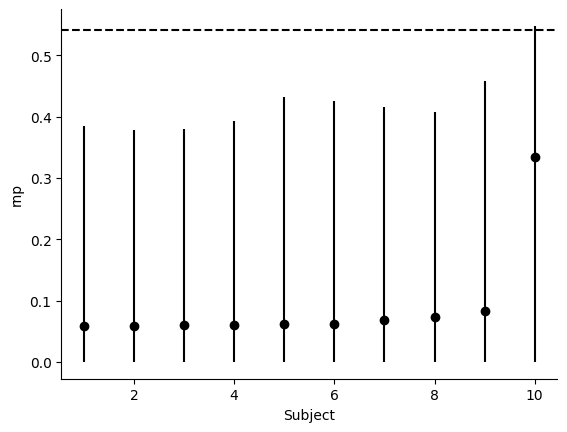

In [27]:
def get_rnp(evidence_sd, prior_std, p=.55):
    beta = prior_std**2 / (evidence_sd**2 + prior_std**2)
    return np.clip(np.exp(-(1./beta) * np.log(1./p)), 0, 1)

idata.posterior['rnp'] = get_rnp(idata.posterior['evidence_sd'], idata.posterior['prior_sd'])
idata.posterior['rnp_mu'] = get_rnp(idata.posterior['evidence_sd_mu'], idata.posterior['prior_sd_mu'])

plot_subjectwise_parameters(idata, parameter='rnp')

### posterior evidence - easier readable 

In [24]:
from bauer.utils.math import softplus_np
import seaborn as sns
import matplotlib.pyplot as plt 
def get_rnp(evidence_sd, prior_std, p=.55):
    beta = prior_std**2 / (evidence_sd**2 + prior_std**2)
    return np.clip(np.exp(-(1./beta) * np.log(1./p)), 0, 1)

sns.set_context('talk')
sns.despine()

<Figure size 640x480 with 0 Axes>

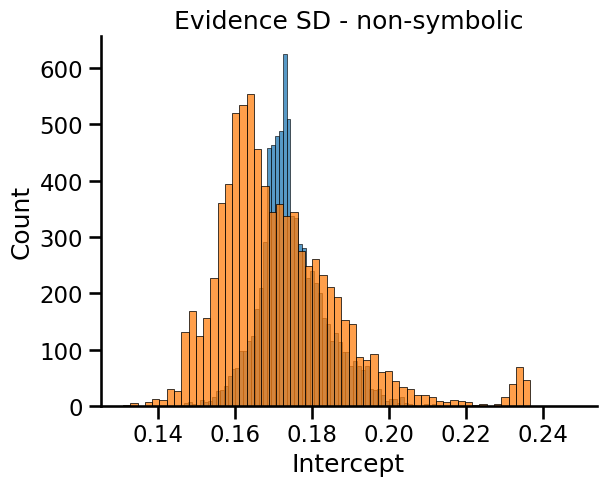

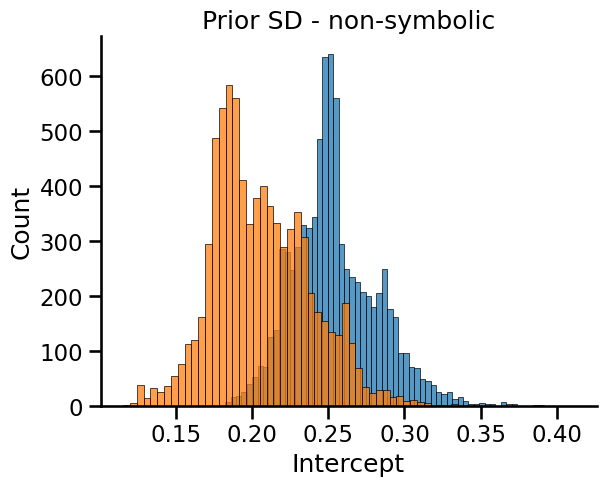

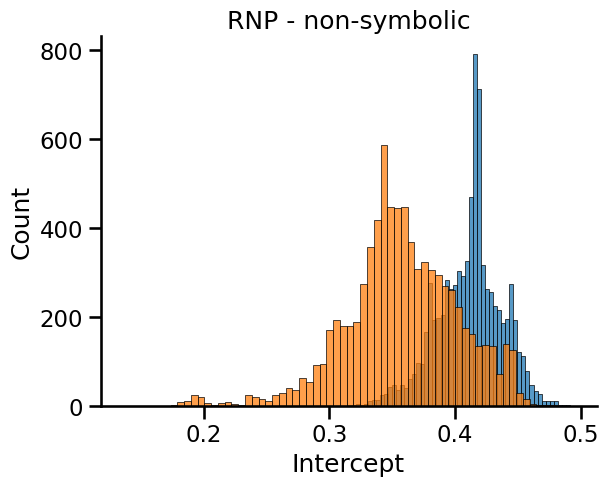

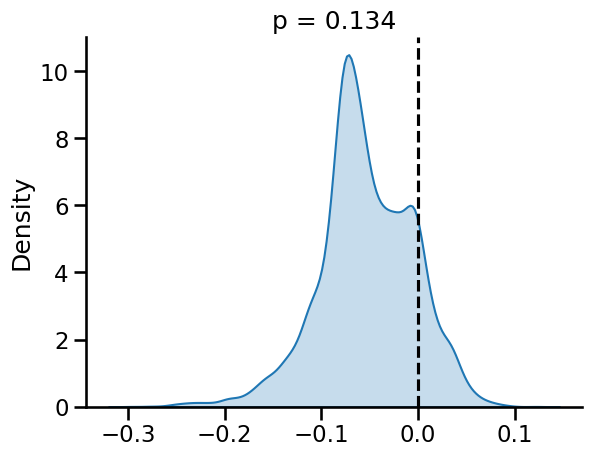

In [27]:
evidence_sd = idata.posterior['evidence_sd_mu'].to_dataframe().unstack('evidence_sd_regressors').droplevel(0, axis=1)

evidence_sd_cc = softplus_np(evidence_sd[('Intercept')])
evidence_sd_dd = softplus_np(evidence_sd[('Intercept')] + evidence_sd[('group')])


prior_sd = idata.posterior['prior_sd_mu'].to_dataframe().unstack('prior_sd_regressors').droplevel(0, axis=1)

prior_sd_cc = softplus_np(prior_sd[('Intercept')])
prior_sd_dd = softplus_np(prior_sd[('Intercept')] + prior_sd[('group')])

sns.histplot(evidence_sd_cc, )
sns.histplot(evidence_sd_dd, )
plt.title(f'Evidence SD - {format}')
sns.despine()

plt.figure()
sns.histplot(prior_sd_cc, )
sns.histplot(prior_sd_dd, )
plt.title(f'Prior SD - {format}')
sns.despine()

rnp_cc = get_rnp(evidence_sd_cc, prior_sd_cc)
rnp_dd = get_rnp(evidence_sd_dd, prior_sd_dd)

plt.figure()
sns.histplot(rnp_cc, )
sns.histplot(rnp_dd, )
plt.title(f'RNP - {format}')
sns.despine()

plt.figure()
sns.kdeplot(rnp_dd - rnp_cc, fill=True)
plt.title(f'p = {np.round(np.mean((rnp_dd - rnp_cc).values > 0), 3)}')

plt.axvline(0.0, c='k', ls='--')
sns.despine()


<Axes: ylabel='Count'>

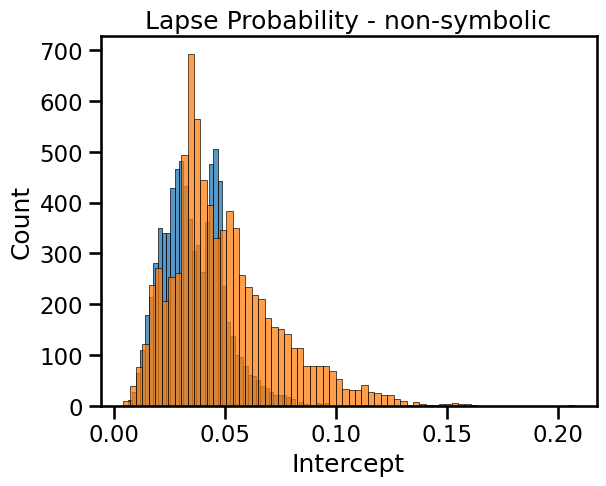

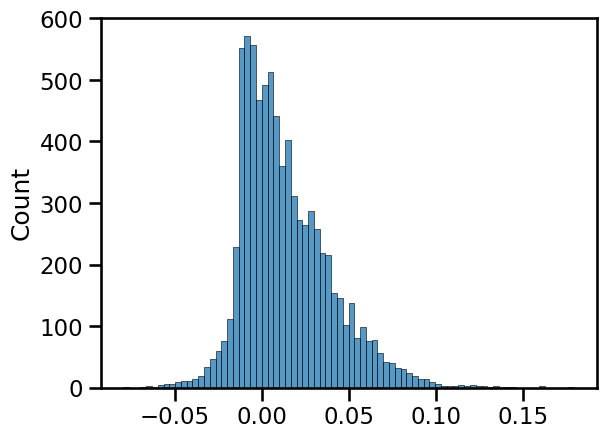

In [28]:
p_lapse = idata.posterior['p_lapse_mu'].to_dataframe().unstack('p_lapse_regressors').droplevel(0, axis=1)

from bauer.utils.math import logistic_np
p_lapse_cc = logistic_np(p_lapse[('Intercept')])
p_lapse_dd = logistic_np(p_lapse[('Intercept')] + p_lapse[('group')])

plt.figure()
sns.histplot(p_lapse_cc, )
sns.histplot(p_lapse_dd, )
plt.title(f'Lapse Probability - {format}')

plt.figure()
sns.histplot(p_lapse_dd - p_lapse_cc)





            rnp          
        hdi_low  hdi_high
subject                  
1           0.0  0.549907
2           0.0  0.549836
3           0.0  0.549927
4           0.0  0.549856
5           0.0  0.549800
...         ...       ...
62          0.0  0.549815
63          0.0  0.549894
64          0.0  0.549389
65          0.0  0.549777
66          0.0  0.549269

[66 rows x 2 columns]


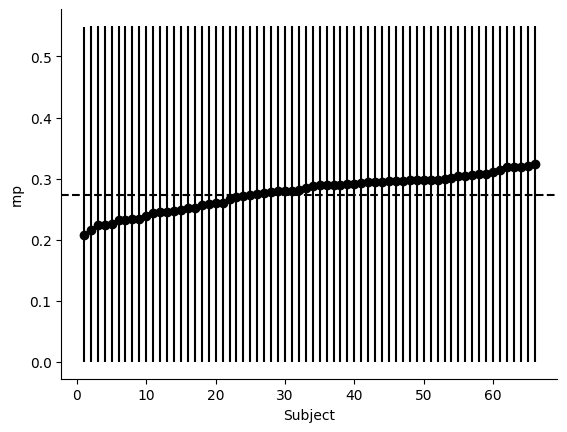

In [8]:
from bauer.utils.plotting import plot_subjectwise_parameters
from utils_02 import get_rnp

idata.posterior['rnp'] = get_rnp(idata.posterior['evidence_sd'], idata.posterior['prior_sd'])
idata.posterior['rnp_mu'] = get_rnp(idata.posterior['evidence_sd_mu'], idata.posterior['prior_sd_mu'])

# plot_subjectwise_parameters(idata, parameter='rnp')

In [9]:
par = 'rnp'
traces = idata.posterior[par+'_mu'].to_dataframe()

In [10]:
traces

rnp_mu
chain draw prior_sd_regressors evidence_sd_regressors               
0     0    Intercept           Intercept                2.138468e-01
                               group                    5.476657e-01
           group               Intercept               2.659749e-186
                               group                    8.053513e-02
      1    Intercept           Intercept                1.957371e-01
...                                                              ...
3     998  group               group                    4.179843e-01
      999  Intercept           Intercept                2.267158e-01
                               group                    5.486943e-01
           group               Intercept                1.372489e-31
                               group                    4.552896e-01

[16000 rows x 1 columns]

Intercept                                                               rnp_mu
chain draw prior_sd_regressors evidence_sd_regressors               
0     0    Intercept           Intercept                2.138468e-01
           group               Intercept               2.659749e-186
      1    Intercept           Intercept                1.957371e-01
           group               Intercept                2.626422e-51
      2    Intercept           Intercept                2.092897e-01
...                                                              ...
3     997  group               Intercept                1.245558e-37
      998  Intercept           Intercept                2.257438e-01
           group               Intercept                1.245558e-37
      999  Intercept           Intercept                2.267158e-01
           group               Intercept                1.372489e-31

[8000 rows x 1 columns]
group                                                          rnp_m

<Figure size 640x480 with 0 Axes>

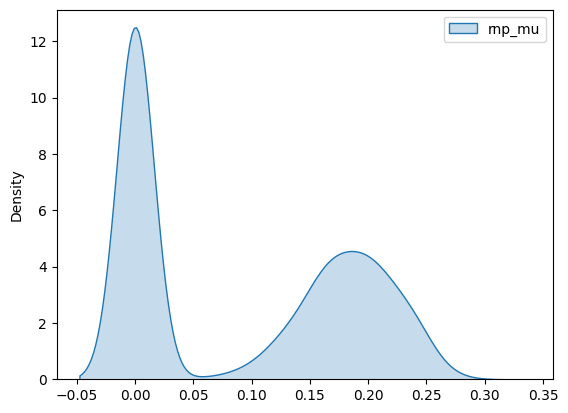

<Figure size 640x480 with 0 Axes>

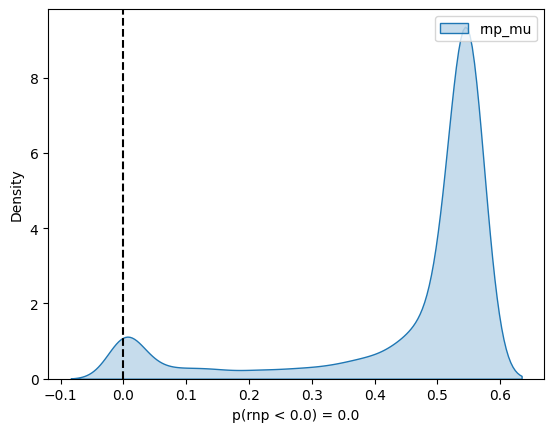

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from bauer.utils.bayes import softplus

#target_folder = op.join(bids_folder, f'derivatives/cogmodels_risk/figures/{model_label}_format-{format}')

par = 'rnp'

for regressor, t in traces.groupby('evidence_sd_regressors'):
            plt.figure()
            t = t.copy()
            print(regressor, t)
            if (par in ['prior_std', 'evidence_sd']) & (regressor == 'Intercept'): #  'risky_prior_std', 'safe_prior_std', 'n1_evidence_sd', 'n2_evidence_sd',
                t = softplus(t)

            plt.figure()
            sns.kdeplot(t, fill=True)
            if regressor != 'Intercept':
                plt.axvline(0.0, c='k', ls='--')
                txt = f'p({par} < 0.0) = {np.round((t.values < 0.0).mean(), 3)}'
                plt.xlabel(txt)


            #plt.savefig(op.join(target_folder, f'group_par-{par}.{regressor}.pdf'))
            #plt.close()
